In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
np.random.seed(5)

In [2]:
def generate_linear(n=100):
    pts = np.random.uniform(0, 1, (n, 2))
    inputs = []
    labels = []
    for pt in pts:
        inputs.append([pt[0], pt[1]])
        if pt[0] > pt[1]:
            labels.append(0)
        else:
            labels.append(1)
    return np.array(inputs), np.array(labels).reshape(n, 1)

def generate_XOR_easy(n=11):
    inputs = []
    labels = []
    step = 1/(n-1)
    for i in range(n):
        inputs.append([step*i, step*i])
        labels.append(0)
        
        if i == int((n-1)/2):
            continue
        
        inputs.append([step*i, 1 - step*i])
        labels.append(1)

    return np.array(inputs), np.array(labels).reshape(n*2 - 1,1)

def show_result(x,y,pred_y):
    plt.subplot(1,2,1)
    plt.title("Ground Truth",fontsize=18)
    for i in range(x.shape[0]):
        if y[i] == 0:
            plt.plot(x[i][0],x[i][1],'ro')
        else:
            plt.plot(x[i][0],x[i][1],'bo')
    plt.subplot(1,2,2)
    plt.title("Predict Result",fontsize=18)
    for i in range(x.shape[0]):
        if pred_y[i] == 0:
            plt.plot(x[i][0],x[i][1],'ro')
        else:
            plt.plot(x[i][0],x[i][1],'bo')
    
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def derivative_sigmoid(x):
    return np.multiply(x, 1.0 - x)

def relu(X):
    X = np.copy(X)
    for i in range(X.shape[1]):
        X[0][i] = max(0.0, X[0][i])
    return X

def derivative_relu(X):
    d_X = np.copy(X)
    for i in range(d_X.shape[1]):
        if(d_X[0][i]>0.0):
            d_X[0][i] = 1.0
        else:
            d_X[0][i] = 0.0
    return d_X

def lrelu(X,a=0.01):
    X = np.copy(X)
    for i in range(X.shape[1]):
        if(X[0][i]<0.0):
            X[0][i] *= a

    return X

def derivative_lrelu(X,a=0.01):
    d_X = np.copy(X)
    for i in range(d_X.shape[1]):
        if(d_X[0][i]>0.0):
            d_X[0][i] = 1.0
        else:
            d_X[0][i] = a
    return d_X

def MSE_loss(y, y_hat):
    return np.mean((y - y_hat)**2)

def derivative_MSE_loss(y, y_hat):
    return (y - y_hat)*(2/y.shape[0])

In [3]:
x1, y1 = generate_linear()
x2, y2 = generate_XOR_easy()

In [4]:
class linear:
    def __init__(self,in_size,out_size,act):
        self.prev_X = np.zeros((1,in_size))
        self.prev_Y = np.zeros((1,out_size))
        self.prev_sig = np.zeros((1,out_size))
        self.W = np.random.uniform(0,1,(in_size,out_size))
        self.W_grad = np.zeros((in_size,out_size))
        self.backward_gradient = np.zeros(out_size)
        self.act = act

        

    #calculate the value W*X, and store X for gradient calculation
    def forward(self,X):
        #self.prev_X = X
        self.prev_X = np.copy(X)
        self.prev_Y = np.matmul(X,self.W)

        if(self.act == 'sigmoid'):
            self.prev_sig = sigmoid(self.prev_Y)
            #return np.copy(self.prev_sig)
            return self.prev_sig
        elif(self.act == 'relu'):
            return relu(self.prev_Y)
        elif(self.act == 'lrelu'):
            return lrelu(self.prev_Y)
        elif(self.act == 'no'):
            return self.prev_Y
            #return np.copy(self.prev_Y)


    def backword(self,derivative):

        if(self.act == 'sigmoid'):
       
            self.backward_gradient=np.copy(derivative_sigmoid(self.prev_sig))
            for i in range(derivative.shape[1]):
                self.backward_gradient[0][i] *= derivative[0][i]
        elif(self.act == 'relu'):
            self.backward_gradient=np.copy(derivative_relu(self.prev_Y))
            for i in range(derivative.shape[1]):
                self.backward_gradient[0][i] *= derivative[0][i]
            
        elif(self.act == 'lrelu'):
            self.backward_gradient=np.copy(derivative_lrelu(self.prev_Y))
            for i in range(derivative.shape[1]):
                self.backward_gradient[0][i] *= derivative[0][i]
            
        elif(self.act == 'no'):
            self.backward_gradient = np.copy(derivative)

        return np.matmul(self.backward_gradient,self.W.T)

    def get_weights(self,learning_rate):
        for i in range(self.prev_X.shape[1]):
            for j in range(self.prev_Y.shape[1]):
                self.W_grad[i][j] -= learning_rate*self.prev_X[0][i]*self.backward_gradient[0][j]

    def update_weights(self,batch_size):

        self.W += self.W_grad/batch_size
        self.W_grad[:] = 0

In [5]:
class My_NN:
    def __init__(self,learning_rate = 1):
        self.layers = []
        self.learning_rate = learning_rate
    def forward(self,X):
        in_data = X
        for l in self.layers:
            in_data = l.forward(in_data)
        return in_data
    def backword(self,derivative):
        back_dev = derivative
        for l in reversed(self.layers):
            back_dev = l.backword(back_dev)
            l.get_weights(self.learning_rate)
        #return back_dev
        
    def add_linear_layer(self,in_size,out_size,act):
        l = linear(in_size,out_size,act)
        self.layers.append(l)
        
    def update_weights(self,batch_size):
        for l in self.layers:
            l.update_weights(batch_size)
    

In [6]:
np.random.seed(5)
linear_nn = My_NN()
linear_nn.add_linear_layer(in_size = 2, out_size = 2, act = 'relu')
linear_nn.add_linear_layer(in_size = 2,out_size = 1, act = 'sigmoid')

In [7]:
log_period = 100
batch_size = len(x1)
epoch_num = 1000

for i in range(epoch_num):
    loss = 0
    for data,label in zip(x1,y1):
        ret = linear_nn.forward(np.array(data).reshape(1,2))       
        loss += MSE_loss(ret,label)    
        linear_nn.backword(derivative_MSE_loss(ret,label))
        
    loss /= batch_size
    linear_nn.update_weights(batch_size)
    if(i%log_period == 0):
        print(f"Epoch {i}:  MSE loss = {loss}")


Epoch 0:  MSE loss = 0.28689482357785656
Epoch 100:  MSE loss = 0.08055694547609728
Epoch 200:  MSE loss = 0.037134710967118324
Epoch 300:  MSE loss = 0.026927679862646915
Epoch 400:  MSE loss = 0.02216558910691016
Epoch 500:  MSE loss = 0.019249855321853266
Epoch 600:  MSE loss = 0.0172020586183926
Epoch 700:  MSE loss = 0.01563270220358501
Epoch 800:  MSE loss = 0.014364948163482999
Epoch 900:  MSE loss = 0.013306204324899927


Confusion Matrix of Linear Problem:
TP:48
TN:52
FP:0
FN:0
Accuracy:1.0
Precision:1.0


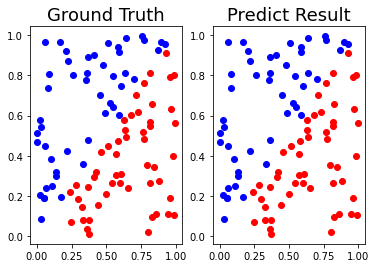

In [8]:
tp = 0
tn = 0
fp = 0
fn = 0
linear_result = []
for data,label in zip(x1,y1):
    ret = linear_nn.forward(np.array(data).reshape(1,2))     
    linear_result.append(1 if ret>0.5 else 0)
    if(ret>0.5 and label==1):
        tp += 1
    elif(ret<=0.5 and label==0):
        tn += 1
    elif(ret<0.5 and label==1):
        fn += 1
    else:
        fp += 1
print("Confusion Matrix of Linear Problem:")
print(f"TP:{tp}")
print(f"TN:{tn}")
print(f"FP:{fp}")
print(f"FN:{fn}")
print(f"Accuracy:{(tp+tn)/len(x1)}")
print(f"Precision:{tp/(tp+fp)}")
show_result(x1,y1,linear_result)


In [9]:
np.random.seed(5)
xor_nn = My_NN()
xor_nn.add_linear_layer(in_size = 2, out_size = 4, act = 'sigmoid')
xor_nn.add_linear_layer(in_size = 4, out_size = 1, act = 'sigmoid')

In [10]:
log_period = 1000
batch_size = len(x2)
epoch_num = 10000

for i in range(epoch_num):
    loss = 0
    for data,label in zip(x2,y2):
        ret = xor_nn.forward(np.array(data).reshape(1,2))       
        loss += MSE_loss(ret,label)    
        xor_nn.backword(derivative_MSE_loss(ret,label))
        
    loss /= batch_size
    xor_nn.update_weights(batch_size)
    if(i%log_period == 0):
        print(f"Epoch {i}:  MSE loss = {loss}")

Epoch 0:  MSE loss = 0.29838936695686724
Epoch 1000:  MSE loss = 0.2314898242829772
Epoch 2000:  MSE loss = 0.11409658501679154
Epoch 3000:  MSE loss = 0.04779418256812241
Epoch 4000:  MSE loss = 0.026388083349986123
Epoch 5000:  MSE loss = 0.015485599931612895
Epoch 6000:  MSE loss = 0.00980239765837774
Epoch 7000:  MSE loss = 0.006717360987618553
Epoch 8000:  MSE loss = 0.004916122940862387
Epoch 9000:  MSE loss = 0.003785030868296672


Confusion Matrix of Linear Problem:
TP:10
TN:11
FP:0
FN:0
Accuracy:1.0
Precision:1.0


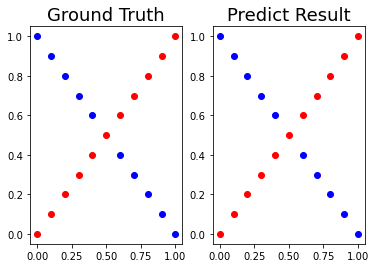

In [11]:
tp = 0
tn = 0
fp = 0
fn = 0
xor_result = []
for data,label in zip(x2,y2):
    ret = xor_nn.forward(np.array(data).reshape(1,2))     
    xor_result.append(1 if ret>0.5 else 0)
    if(ret>0.5 and label==1):
        tp += 1
    elif(ret<=0.5 and label==0):
        tn += 1
    elif(ret<0.5 and label==1):
        fn += 1
    else:
        fp += 1
print("Confusion Matrix of Linear Problem:")
print(f"TP:{tp}")
print(f"TN:{tn}")
print(f"FP:{fp}")
print(f"FN:{fn}")
print(f"Accuracy:{(tp+tn)/len(x2)}")
print(f"Precision:{tp/(tp+fp)}")
show_result(x2,y2,xor_result)